#=========================
#- - - - - - -< 최종v3 >- - - - - - - -
#=========================

## V3학습

In [ ]:
# =========================
# 하이브리드 MobileNetV2 위변조 탐지 모델
# 기존 MobileNetV2 백본 + 주파수 브랜치 + MIL + Focal Loss + OHEM
# =========================
import os, random, io, math, time
from collections import Counter
import numpy as np
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF

# =========================
# 기존 MobileNetV2 구현 (그대로 유지)
# =========================

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ])

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        return self.conv(x)

class MobileNetV2Backbone(nn.Module):
    """기존 MobileNetV2와 동일한 백본 (features만 추출)"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layers = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 320, 1, 6),
        )

        self.conv_last = nn.Conv2d(320, 1280, 1, bias=False)
        self.bn_last = nn.BatchNorm2d(1280)

    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = F.relu6(self.bn_last(self.conv_last(x)))
        return x

# =========================
# 주파수 브랜치 모듈들
# =========================

class SRMExtractor(nn.Module):
    """Statistical Residual Model - 9개 고주파 필터"""
    def __init__(self, out_ch=64):
        super().__init__()
        kernels = [
            [[0, 0, 0],[0, 1,-1],[0, 0, 0]],
            [[0, 0, 0],[1,-2, 1],[0, 0, 0]],
            [[0, 1, 0],[1,-4, 1],[0, 1, 0]],
            [[-1, 2,-1],[2,-4, 2],[-1, 2,-1]],
            [[1,-1, 0],[-1, 0, 1],[0, 1,-1]],
            [[0,-1, 0],[-1, 4,-1],[0,-1, 0]],
            [[-1, 0, 1],[0, 0, 0],[1, 0,-1]],
            [[-1,-1,-1],[-1, 8,-1],[-1,-1,-1]],
            [[2,-1, 2],[-1,-4,-1],[2,-1, 2]],
        ]
        k = torch.tensor(kernels, dtype=torch.float32).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(len(kernels), out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch, affine=False)
        self.act = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))

    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))

class HPFExtractor(nn.Module):
    """High-Pass Filter - Laplacian, Sobel, Sharpen"""
    def __init__(self, out_ch=96):
        super().__init__()
        lap = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=torch.float32)
        sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32)
        sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32)
        sharp = torch.tensor([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=torch.float32)
        k = torch.stack([lap, sobel_x, sobel_y, sharp], dim=0).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(4, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch, affine=False)
        self.act = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))

    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), stride=1, padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))

# =========================
# 하이브리드 모델 정의
# =========================

class HybridMobileNetV2Forensics(nn.Module):
    def __init__(self, num_classes=2, topk_ratio=0.06, dropout_p=0.2):
        super().__init__()

        # 기존 MobileNetV2 백본 사용
        self.backbone = MobileNetV2Backbone()

        # 주파수 브랜치들
        self.srm = SRMExtractor(out_ch=64)
        self.hpf = HPFExtractor(out_ch=96)

        # 채널 병합 (1280 + 64 + 96 = 1440)
        merged_ch = 1280 + 64 + 96
        self.dropout = nn.Dropout(dropout_p)

        # 분류기 맵 (MIL용)
        self.classifier_map = nn.Conv2d(merged_ch, num_classes, kernel_size=1, bias=True)

        # MIL pooling 설정
        self.topk_ratio = topk_ratio

    def set_topk(self, ratio):
        """MIL pooling의 top-k 비율 설정"""
        self.topk_ratio = float(ratio)

    def forward(self, x, return_map=False):
        # 백본 특징 추출
        feat = self.backbone(x)  # Bx1280xhxw
        B, _, h, w = feat.shape

        # 주파수 브랜치들 (입력 이미지에서 처리 후 h,w로 다운샘플)
        srm = F.adaptive_avg_pool2d(self.srm(x), (h, w))  # Bx64xhxw
        hpf = F.adaptive_avg_pool2d(self.hpf(x), (h, w))  # Bx96xhxw

        # 모든 특징 병합
        x_cat = torch.cat([feat, srm, hpf], dim=1)  # Bx1440xhxw
        x_cat = self.dropout(x_cat)

        # 분류기 맵 생성
        logit_map = self.classifier_map(x_cat)  # Bx2xhxw

        if return_map:
            return logit_map

        # Per-class Top-k MIL pooling
        B, C, H, W = logit_map.shape  # C=2
        pooled_ch = []

        for c in range(C):
            logits_c = logit_map[:, c, :, :].reshape(B, -1)  # B x (HW)
            k = max(1, int(self.topk_ratio * logits_c.shape[1]))
            topk_vals, topk_idx = torch.topk(logits_c, k, dim=1)

            # 마스크 생성
            mask_c = torch.zeros_like(logits_c)
            mask_c.scatter_(1, topk_idx, 1.0)
            mask_c = mask_c.view(B, 1, H, W)

            # 마스크 적용한 평균
            pooled_c = (logit_map[:, c:c+1, :, :] * mask_c).sum(dim=(2,3)) / mask_c.sum(dim=(2,3)).clamp_min(1.0)
            pooled_ch.append(pooled_c)

        pooled = torch.cat(pooled_ch, dim=1)  # Bx2
        return pooled

# =========================
# 고급 손실 함수들
# =========================

class FocalLossAlphaPerSample(nn.Module):
    def __init__(self, gamma=2.0, alpha=(0.5, 0.5)):
        super().__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha, dtype=torch.float32)

    def forward(self, logits, target, reduction='none'):
        logp = F.log_softmax(logits, dim=1)
        p = logp.exp()
        focal = (1 - p).pow(self.gamma) * logp
        loss = F.nll_loss(focal, target, reduction='none')
        a = self.alpha.to(logits.device)
        loss = loss * a[target]
        if reduction == 'mean':
            return loss.mean()
        return loss

class ClassBalancedOHEM(nn.Module):
    """각 클래스별로 어려운 샘플들만 선별하여 학습"""
    def __init__(self, base_per_sample_loss, keep_ratio=0.5):
        super().__init__()
        self.base = base_per_sample_loss
        self.keep_ratio = keep_ratio

    def forward(self, logits, target):
        losses = self.base(logits, target, reduction='none')
        kept = []

        for c in [0, 1]:
            idx = (target == c).nonzero(as_tuple=False).view(-1)
            if idx.numel() == 0:
                continue
            lc = losses[idx]
            k = max(1, int(self.keep_ratio * lc.numel()))
            kept.append(torch.topk(lc, k).values)

        if not kept:
            return losses.mean()
        return torch.cat(kept).mean()

# =========================
# 훈련 설정 및 데이터
# =========================

# 경로 및 하이퍼파라미터
data_root = "/content/drive/MyDrive/MRI_train"
save_dir = "/content/drive/MyDrive/MRI_hybrid_checkpoints"
os.makedirs(save_dir, exist_ok=True)

img_size = 224
batch_size = 16
epochs = 60
base_lr = 1e-3
weight_decay = 1e-4
early_patience = 5  # 작은 데이터셋에 적합한 설정

# MIL pooling 스케줄
MIL_TOPK_SCHEDULE = [1.00, 0.25, 0.10, 0.06]

# Focal Loss 설정
FOCAL_ALPHA = (0.6, 0.4)  # (fake, real)
FOCAL_GAMMA = 1.5

# OHEM 설정
OHEM_KEEP_RATIO = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] device={device}")

# 재현성
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_all(42)

# 데이터 변환
eval_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_tf = eval_tf  # 증강 없이 시작

# 데이터셋 준비
full_ds = datasets.ImageFolder(root=data_root)
class_to_idx = full_ds.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("[INFO] classes:", class_to_idx)

# Stratified split
targets = [y for _,y in full_ds.samples]
indices_by_class = {}
for i,y in enumerate(targets):
    indices_by_class.setdefault(y, []).append(i)

train_idx, val_idx = [], []
val_ratio = 0.1
random.seed(42)
for y, idxs in indices_by_class.items():
    random.shuffle(idxs)
    n_val = max(1, int(len(idxs)*val_ratio))
    val_idx.extend(idxs[:n_val])
    train_idx.extend(idxs[n_val:])

# 데이터셋 및 로더
train_full_ds = datasets.ImageFolder(root=data_root, transform=train_tf)
val_full_ds = datasets.ImageFolder(root=data_root, transform=eval_tf)
train_ds = Subset(train_full_ds, train_idx)
val_ds = Subset(val_full_ds, val_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"[INFO] train={len(train_ds)} val={len(val_ds)}")

# =========================
# 훈련 함수들
# =========================

def run_epoch(model, loader, criterion, optimizer=None, train_mode=True):
    model.train() if train_mode else model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            logits = model(x)
            loss = criterion(logits, y)

            if train_mode:
                loss.backward()
                optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        if train_mode and (i % 20 == 0):
            print(f" batch {i:05d}/{len(loader):05d} | loss {loss.item():.4f}", flush=True)

    return loss_sum / max(1, total), 100.0 * correct / max(1, total)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    cm = torch.zeros(2, 2, dtype=torch.int64)
    total, correct = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)

        for t, p in zip(y.view(-1), pred.view(-1)):
            cm[t.long(), p.long()] += 1

        total += y.size(0)
        correct += (pred == y).sum().item()

    acc = 100.0 * correct / max(1, total)
    return acc, cm

def print_cm(tag, acc, cm):
    print(f"\n=== {tag} ===")
    print(f"Accuracy: {acc:.2f}%")
    print(f"Confusion Matrix:")
    print(f" pred-> class0 class1")
    print(f"true 0 {int(cm[0,0]):6d} {int(cm[0,1]):6d}")
    print(f"true 1 {int(cm[1,0]):6d} {int(cm[1,1]):6d}")

def train_model(model, model_name):
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # 손실 함수 설정 (Focal Loss + OHEM)
    base_loss = FocalLossAlphaPerSample(gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA)
    criterion = ClassBalancedOHEM(base_per_sample_loss=base_loss, keep_ratio=OHEM_KEEP_RATIO)

    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val = float('inf')
    wait = 0
    best_path = os.path.join(save_dir, f'{model_name}_best.pth')

    start_time = time.time()

    for ep in range(1, epochs+1):
        # MIL pooling 스케줄 업데이트
        stage = min(len(MIL_TOPK_SCHEDULE)-1, (ep-1) // (epochs//len(MIL_TOPK_SCHEDULE)))
        model.set_topk(MIL_TOPK_SCHEDULE[stage])

        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer, True)
        vl_loss, vl_acc = run_epoch(model, val_loader, criterion, None, False)
        scheduler.step(vl_loss)

        print(f"Epoch {ep:02d}/{epochs} | train_loss {tr_loss:.4f} acc {tr_acc:.2f}% | val_loss {vl_loss:.4f} acc {vl_acc:.2f}% | topk_ratio {model.topk_ratio:.2f}")

        if vl_loss < best_val:
            best_val, wait = vl_loss, 0
            torch.save(model.state_dict(), best_path)
            print(f" 💾 Best updated: {best_path} (val_loss={best_val:.4f})")
        else:
            wait += 1
            if wait >= early_patience:
                print(" ⛳ Early stopped.")
                break

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    last_path = os.path.join(save_dir, f'{model_name}_last.pth')
    torch.save(model.state_dict(), last_path)
    print(f"✅ Saved last: {last_path}")

    return best_path, training_time

def evaluate_model(model, model_name, best_path):
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")

    model.load_state_dict(torch.load(best_path, map_location=device))
    model = model.to(device)

    acc, cm = evaluate(model, val_loader)
    print_cm("Eval (baseline)", acc, cm)

# =========================
# 메인 실행
# =========================

if __name__ == '__main__':
    print("Starting Hybrid MobileNetV2 + Forensics training...")
    print(f"Classes mapping: {idx_to_class}")

    model_name = "HybridMobileNetV2_Forensics"
    model = HybridMobileNetV2Forensics(
        num_classes=2,
        topk_ratio=MIL_TOPK_SCHEDULE[0],
        dropout_p=0.2
    ).to(device)

    # 파라미터 수 출력
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # 모델 구성 요소별 파라미터 수
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    srm_params = sum(p.numel() for p in model.srm.parameters())
    hpf_params = sum(p.numel() for p in model.hpf.parameters())
    print(f"Backbone: {backbone_params:,}, SRM: {srm_params:,}, HPF: {hpf_params:,}")

    try:
        # 훈련
        best_path, training_time = train_model(model, model_name)

        # 평가
        evaluate_model(model, model_name, best_path)

        print(f"\n✅ {model_name} completed successfully!")
        print(f"Training time: {training_time:.1f}s")
        print(f"Best model saved: {best_path}")

    except Exception as e:
        print(f"❌ Error training {model_name}: {str(e)}")

    finally:
        # 메모리 정리
        torch.cuda.empty_cache()

    print(f"\n✅ Hybrid training pipeline completed!")
    print(f"Results saved in: {save_dir}")

[INFO] device=cuda
[INFO] classes: {'fake': 0, 'real': 1}
[INFO] train=880 val=97
Starting Hybrid MobileNetV2 + Forensics training...
Classes mapping: {0: 'fake', 1: 'real'}
Total parameters: 2,227,714
Trainable parameters: 2,227,714
Backbone: 2,223,872, SRM: 576, HPF: 384

Training HybridMobileNetV2_Forensics
 batch 00000/00055 | loss 0.1807
 batch 00020/00055 | loss 0.1679
 batch 00040/00055 | loss 0.1694
Epoch 01/60 | train_loss 0.1693 acc 52.84% | val_loss 0.1592 acc 51.55% | topk_ratio 1.00
 💾 Best updated: /content/drive/MyDrive/MRI_hybrid_checkpoints/HybridMobileNetV2_Forensics_best.pth (val_loss=0.1592)
 batch 00000/00055 | loss 0.1244
 batch 00020/00055 | loss 0.1774
 batch 00040/00055 | loss 0.0326
Epoch 02/60 | train_loss 0.1164 acc 77.95% | val_loss 0.1212 acc 65.98% | topk_ratio 1.00
 💾 Best updated: /content/drive/MyDrive/MRI_hybrid_checkpoints/HybridMobileNetV2_Forensics_best.pth (val_loss=0.1212)
 batch 00000/00055 | loss 0.2414
 batch 00020/00055 | loss 0.0989
 batch 0

##V3테스트

In [ ]:
# =========================
# 하이브리드 MobileNetV2 모델 테스트 코드
# argmax 기반 평가 + 혼동 매트릭스
# =========================
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# =========================
# 동일한 모델 구조 재정의 (테스트용)
# =========================

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ])

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        return self.conv(x)

class MobileNetV2Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layers = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 320, 1, 6),
        )

        self.conv_last = nn.Conv2d(320, 1280, 1, bias=False)
        self.bn_last = nn.BatchNorm2d(1280)

    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = F.relu6(self.bn_last(self.conv_last(x)))
        return x

class SRMExtractor(nn.Module):
    def __init__(self, out_ch=64):
        super().__init__()
        kernels = [
            [[0, 0, 0],[0, 1,-1],[0, 0, 0]],
            [[0, 0, 0],[1,-2, 1],[0, 0, 0]],
            [[0, 1, 0],[1,-4, 1],[0, 1, 0]],
            [[-1, 2,-1],[2,-4, 2],[-1, 2,-1]],
            [[1,-1, 0],[-1, 0, 1],[0, 1,-1]],
            [[0,-1, 0],[-1, 4,-1],[0,-1, 0]],
            [[-1, 0, 1],[0, 0, 0],[1, 0,-1]],
            [[-1,-1,-1],[-1, 8,-1],[-1,-1,-1]],
            [[2,-1, 2],[-1,-4,-1],[2,-1, 2]],
        ]
        k = torch.tensor(kernels, dtype=torch.float32).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(len(kernels), out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch, affine=False)
        self.act = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))

    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))

class HPFExtractor(nn.Module):
    def __init__(self, out_ch=96):
        super().__init__()
        lap = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=torch.float32)
        sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32)
        sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32)
        sharp = torch.tensor([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=torch.float32)
        k = torch.stack([lap, sobel_x, sobel_y, sharp], dim=0).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(4, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch, affine=False)
        self.act = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))

    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), stride=1, padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))

class HybridMobileNetV2Forensics(nn.Module):
    def __init__(self, num_classes=2, topk_ratio=0.06, dropout_p=0.2):
        super().__init__()
        self.backbone = MobileNetV2Backbone()
        self.srm = SRMExtractor(out_ch=64)
        self.hpf = HPFExtractor(out_ch=96)

        merged_ch = 1280 + 64 + 96
        self.dropout = nn.Dropout(dropout_p)
        self.classifier_map = nn.Conv2d(merged_ch, num_classes, kernel_size=1, bias=True)
        self.topk_ratio = topk_ratio

    def set_topk(self, ratio):
        self.topk_ratio = float(ratio)

    def forward(self, x, return_map=False):
        feat = self.backbone(x)
        B, _, h, w = feat.shape

        srm = F.adaptive_avg_pool2d(self.srm(x), (h, w))
        hpf = F.adaptive_avg_pool2d(self.hpf(x), (h, w))

        x_cat = torch.cat([feat, srm, hpf], dim=1)
        x_cat = self.dropout(x_cat)
        logit_map = self.classifier_map(x_cat)

        if return_map:
            return logit_map

        # Per-class Top-k MIL pooling
        B, C, H, W = logit_map.shape
        pooled_ch = []

        for c in range(C):
            logits_c = logit_map[:, c, :, :].reshape(B, -1)
            k = max(1, int(self.topk_ratio * logits_c.shape[1]))
            topk_vals, topk_idx = torch.topk(logits_c, k, dim=1)

            mask_c = torch.zeros_like(logits_c)
            mask_c.scatter_(1, topk_idx, 1.0)
            mask_c = mask_c.view(B, 1, H, W)

            pooled_c = (logit_map[:, c:c+1, :, :] * mask_c).sum(dim=(2,3)) / mask_c.sum(dim=(2,3)).clamp_min(1.0)
            pooled_ch.append(pooled_c)

        pooled = torch.cat(pooled_ch, dim=1)
        return pooled

# =========================
# 테스트 설정
# =========================

# 경로 설정 (실제 경로로 수정하세요)
model_path = "/content/drive/MyDrive/MRI_hybrid_checkpoints/HybridMobileNetV2_Forensics_best.pth"
test_data_root = "/content/drive/MyDrive/MRI_test"  # 또는 별도 테스트 데이터 경로

# 하이퍼파라미터
img_size = 224
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 재현성
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)

# =========================
# 데이터 준비
# =========================

# 데이터 변환 (훈련 시와 동일)
test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# 테스트 데이터셋 로드
test_dataset = datasets.ImageFolder(root=test_data_root, transform=test_tf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

class_to_idx = test_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print(f"[INFO] Test dataset loaded")
print(f"[INFO] Classes: {class_to_idx}")
print(f"[INFO] Total test samples: {len(test_dataset)}")
print(f"[INFO] Device: {device}")

# =========================
# 평가 함수들
# =========================

@torch.no_grad()
def evaluate_model_argmax(model, loader):
    """argmax 기반 모델 평가"""
    model.eval()

    # 전체 예측 결과 저장
    all_predictions = []
    all_targets = []
    all_probabilities = []

    # 혼동 매트릭스 초기화
    num_classes = len(class_to_idx)
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    total_samples = 0
    correct_predictions = 0

    print("\n[INFO] 모델 평가 시작...")

    for batch_idx, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)

        # 모델 예측
        logits = model(images)
        probabilities = F.softmax(logits, dim=1)
        predictions = logits.argmax(dim=1)

        # 결과 저장
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

        # 혼동 매트릭스 업데이트
        for t, p in zip(targets.view(-1), predictions.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

        # 정확도 계산
        correct_predictions += (predictions == targets).sum().item()
        total_samples += targets.size(0)

        # 진행 상황 출력
        if batch_idx % 10 == 0:
            print(f"  배치 {batch_idx+1}/{len(loader)} 처리 완료")

    # 전체 정확도
    overall_accuracy = 100.0 * correct_predictions / total_samples

    return {
        'overall_accuracy': overall_accuracy,
        'confusion_matrix': confusion_matrix,
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets),
        'probabilities': np.array(all_probabilities),
        'total_samples': total_samples,
        'correct_predictions': correct_predictions
    }

def print_detailed_results(results):
    """상세한 결과 출력"""
    cm = results['confusion_matrix']
    total_samples = results['total_samples']
    overall_acc = results['overall_accuracy']

    print("\n" + "="*60)
    print("🔍 하이브리드 모델 테스트 결과")
    print("="*60)

    # 전체 정확도
    print(f"\n📊 전체 정확도: {overall_acc:.2f}% ({results['correct_predictions']}/{total_samples})")

    # 혼동 매트릭스
    print(f"\n📋 혼동 매트릭스 (Confusion Matrix):")
    print("   " + "".join([f"{idx_to_class.get(i, f'Class{i}'):>12}" for i in range(len(class_to_idx))]))
    for i in range(len(class_to_idx)):
        row_label = idx_to_class.get(i, f'Class{i}')
        row_values = "".join([f"{int(cm[i, j]):12d}" for j in range(len(class_to_idx))])
        print(f"{row_label:>8} {row_values}")

    # 클래스별 상세 성능
    print(f"\n📈 클래스별 상세 성능:")
    print("-" * 80)
    print(f"{'클래스':>10} {'정확도':>8} {'정밀도':>8} {'재현율':>8} {'F1-Score':>10} {'샘플 수':>8}")
    print("-" * 80)

    class_accuracies = []
    for i in range(len(class_to_idx)):
        # True Positive, False Positive, False Negative 계산
        tp = cm[i, i].item()
        fp = cm[:, i].sum().item() - tp
        fn = cm[i, :].sum().item() - tp
        tn = cm.sum().item() - tp - fp - fn

        # 메트릭 계산
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        class_name = idx_to_class.get(i, f'Class{i}')
        total_class_samples = cm[i, :].sum().item()

        print(f"{class_name:>10} {accuracy*100:7.2f}% {precision*100:7.2f}% {recall*100:7.2f}% {f1*100:9.2f}% {total_class_samples:8d}")
        class_accuracies.append(recall)  # 클래스별 재현율 저장

    # 균형 정확도 (Balanced Accuracy)
    balanced_accuracy = np.mean(class_accuracies) * 100
    print("-" * 80)
    print(f"{'균형 정확도':>10} {balanced_accuracy:7.2f}%")

    # 클래스 분포
    print(f"\n📋 클래스 분포:")
    for i in range(len(class_to_idx)):
        class_name = idx_to_class.get(i, f'Class{i}')
        class_count = cm[i, :].sum().item()
        class_ratio = class_count / total_samples * 100
        print(f"  {class_name}: {class_count:4d} 샘플 ({class_ratio:5.1f}%)")

    return {
        'balanced_accuracy': balanced_accuracy,
        'class_accuracies': class_accuracies
    }

# =========================
# 메인 테스트 실행
# =========================

def main():
    print("하이브리드 MobileNetV2 모델 테스트 시작...")

    # 모델 로드
    print(f"\n[INFO] 모델 로드 중: {model_path}")

    try:
        # 모델 초기화
        model = HybridMobileNetV2Forensics(
            num_classes=len(class_to_idx),
            topk_ratio=0.06,  # 테스트 시에는 고정값 사용
            dropout_p=0.2
        ).to(device)

        # 가중치 로드
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"[SUCCESS] 모델 로드 완료")


        # 모델 정보
        total_params = sum(p.numel() for p in model.parameters())
        print(f"[INFO] 총 파라미터 수: {total_params:,}")

    except Exception as e:
        print(f"[ERROR] 모델 로드 실패: {str(e)}")
        return

    # 모델 평가
    results = evaluate_model_argmax(model, test_loader)

    # 결과 출력
    detailed_results = print_detailed_results(results)

    # 요약 정보
    print(f"\n🎯 최종 요약:")
    print(f"  • 전체 정확도: {results['overall_accuracy']:.2f}%")
    print(f"  • 균형 정확도: {detailed_results['balanced_accuracy']:.2f}%")
    print(f"  • 총 테스트 샘플: {results['total_samples']:,}")

    print(f"\n✅ 테스트 완료!")

if __name__ == '__main__':
    main()

[INFO] Test dataset loaded
[INFO] Classes: {'fake': 0, 'real': 1}
[INFO] Total test samples: 1000
[INFO] Device: cuda
하이브리드 MobileNetV2 모델 테스트 시작...

[INFO] 모델 로드 중: /content/drive/MyDrive/MRI_hybrid_checkpoints/HybridMobileNetV2_Forensics_best.pth
[SUCCESS] 모델 로드 완료
[INFO] 총 파라미터 수: 2,227,714

[INFO] 모델 평가 시작...
  배치 1/63 처리 완료
  배치 11/63 처리 완료
  배치 21/63 처리 완료
  배치 31/63 처리 완료
  배치 41/63 처리 완료
  배치 51/63 처리 완료
  배치 61/63 처리 완료

🔍 하이브리드 모델 테스트 결과

📊 전체 정확도: 76.30% (763/1000)

📋 혼동 매트릭스 (Confusion Matrix):
           fake        real
    fake          301         199
    real           38         462

📈 클래스별 상세 성능:
--------------------------------------------------------------------------------
       클래스      정확도      정밀도      재현율   F1-Score     샘플 수
--------------------------------------------------------------------------------
      fake   76.30%   88.79%   60.20%     71.75%      500
      real   76.30%   69.89%   92.40%     79.59%      500
-----------------------------------------

##V3 임계값 적용하여 테스트 코드

하이브리드 MobileNetV2 모델 테스트 시작...
[INFO] 모델 로드 완료

=== 임계값 적용 결과 (Youden 기준) ===
Optimal Threshold: 0.8064
ROC AUC: 0.8592
Total Accuracy: 79.20%
Real Accuracy : 72.60%
Fake Accuracy : 85.80%
Confusion Matrix:
[[363 137]
 [ 71 429]]


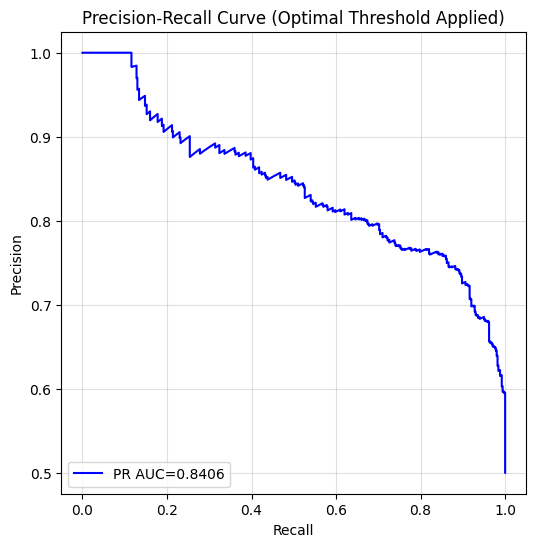


✅ 테스트 완료! (임계값 0.8064 기준으로 평가됨)


In [3]:
# =========================
# 하이브리드 MobileNetV2 모델 테스트 (Youden 임계값만 적용)
# =========================
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# =========================
# 모델 정의
# =========================

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ])

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        return self.conv(x)


class MobileNetV2Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 320, 1, 6),
        )
        self.conv_last = nn.Conv2d(320, 1280, 1, bias=False)
        self.bn_last = nn.BatchNorm2d(1280)

    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = F.relu6(self.bn_last(self.conv_last(x)))
        return x


class SRMExtractor(nn.Module):
    def __init__(self, out_ch=64):
        super().__init__()
        kernels = [
            [[0, 0, 0],[0, 1,-1],[0, 0, 0]],
            [[0, 0, 0],[1,-2, 1],[0, 0, 0]],
            [[0, 1, 0],[1,-4, 1],[0, 1, 0]],
            [[-1, 2,-1],[2,-4, 2],[-1, 2,-1]],
            [[1,-1, 0],[-1, 0, 1],[0, 1,-1]],
            [[0,-1, 0],[-1, 4,-1],[0,-1, 0]],
            [[-1, 0, 1],[0, 0, 0],[1, 0,-1]],
            [[-1,-1,-1],[-1, 8,-1],[-1,-1,-1]],
            [[2,-1, 2],[-1,-4,-1],[2,-1, 2]],
        ]
        k = torch.tensor(kernels, dtype=torch.float32).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(len(kernels), out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch, affine=False)
        self.act = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))

    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))


class HPFExtractor(nn.Module):
    def __init__(self, out_ch=96):
        super().__init__()
        lap = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=torch.float32)
        sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32)
        sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32)
        sharp = torch.tensor([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=torch.float32)
        k = torch.stack([lap, sobel_x, sobel_y, sharp], dim=0).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(4, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch, affine=False)
        self.act = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))

    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), stride=1, padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))


class HybridMobileNetV2Forensics(nn.Module):
    def __init__(self, num_classes=2, topk_ratio=0.06, dropout_p=0.2):
        super().__init__()
        self.backbone = MobileNetV2Backbone()
        self.srm = SRMExtractor(out_ch=64)
        self.hpf = HPFExtractor(out_ch=96)
        merged_ch = 1280 + 64 + 96
        self.dropout = nn.Dropout(dropout_p)
        self.classifier_map = nn.Conv2d(merged_ch, num_classes, 1)
        self.topk_ratio = topk_ratio

    def forward(self, x):
        feat = self.backbone(x)
        B, _, h, w = feat.shape
        srm = F.adaptive_avg_pool2d(self.srm(x), (h, w))
        hpf = F.adaptive_avg_pool2d(self.hpf(x), (h, w))
        x_cat = torch.cat([feat, srm, hpf], dim=1)
        x_cat = self.dropout(x_cat)
        logit_map = self.classifier_map(x_cat)
        B, C, H, W = logit_map.shape
        pooled = []
        for c in range(C):
            vals = logit_map[:, c, :, :].reshape(B, -1)
            k = max(1, int(self.topk_ratio * vals.shape[1]))
            topk_vals, _ = torch.topk(vals, k, dim=1)
            pooled.append(topk_vals.mean(1, keepdim=True))
        return torch.cat(pooled, dim=1)

# =========================
# 테스트 설정
# =========================
model_path = "/content/drive/MyDrive/MRI_hybrid_checkpoints/HybridMobileNetV2_Forensics_best.pth"
test_data_root = "/content/drive/MyDrive/MRI_test"

img_size = 224
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_all(42)

test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
test_dataset = datasets.ImageFolder(root=test_data_root, transform=test_tf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
class_to_idx = test_dataset.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}


# =========================
# 평가 함수
# =========================
@torch.no_grad()
def get_probs_labels(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    for x, y in loader:
        x = x.to(device)
        probs = F.softmax(model(x), dim=1)[:,1].cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.numpy())
    return np.array(all_probs), np.array(all_labels)


@torch.no_grad()
def find_optimal_threshold(model, loader):
    probs, labels = get_probs_labels(model, loader)
    fpr, tpr, thr = roc_curve(labels, probs)
    youden_idx = np.argmax(tpr - fpr)
    youden_thr = thr[youden_idx]
    auc_score = auc(fpr, tpr)
    return youden_thr, auc_score, fpr, tpr, probs, labels


def evaluate_with_threshold(probs, labels, thr):
    preds = (probs > thr).astype(int)
    cm = confusion_matrix(labels, preds)
    acc_total = accuracy_score(labels, preds) * 100
    real_acc = cm[0,0] / cm[0].sum() * 100
    fake_acc = cm[1,1] / cm[1].sum() * 100
    return acc_total, real_acc, fake_acc, cm


# =========================
# 메인 실행
# =========================
def main():
    print("하이브리드 MobileNetV2 모델 테스트 시작...")
    model = HybridMobileNetV2Forensics(num_classes=len(class_to_idx)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("[INFO] 모델 로드 완료")

    # 1️⃣ 최적 임계값 탐색
    thr, auc_score, fpr, tpr, probs, labels = find_optimal_threshold(model, test_loader)

    # 2️⃣ 해당 임계값 적용 평가
    acc_total, real_acc, fake_acc, cm = evaluate_with_threshold(probs, labels, thr)

    # 3️⃣ 결과 출력
    print("\n=== 임계값 적용 결과 (Youden 기준) ===")
    print(f"Optimal Threshold: {thr:.4f}")
    print(f"ROC AUC: {auc_score:.4f}")
    print(f"Total Accuracy: {acc_total:.2f}%")
    print(f"Real Accuracy : {real_acc:.2f}%")
    print(f"Fake Accuracy : {fake_acc:.2f}%")
    print("Confusion Matrix:")
    print(cm)

    # 4️⃣ Precision-Recall Curve 시각화
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, color='blue', label=f"PR AUC={pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Optimal Threshold Applied)")
    plt.legend(loc="lower left")
    plt.grid(alpha=0.4)
    plt.show()

    print(f"\n✅ 테스트 완료! (임계값 {thr:.4f} 기준으로 평가됨)")

if __name__ == '__main__':
    main()


##V3시각화

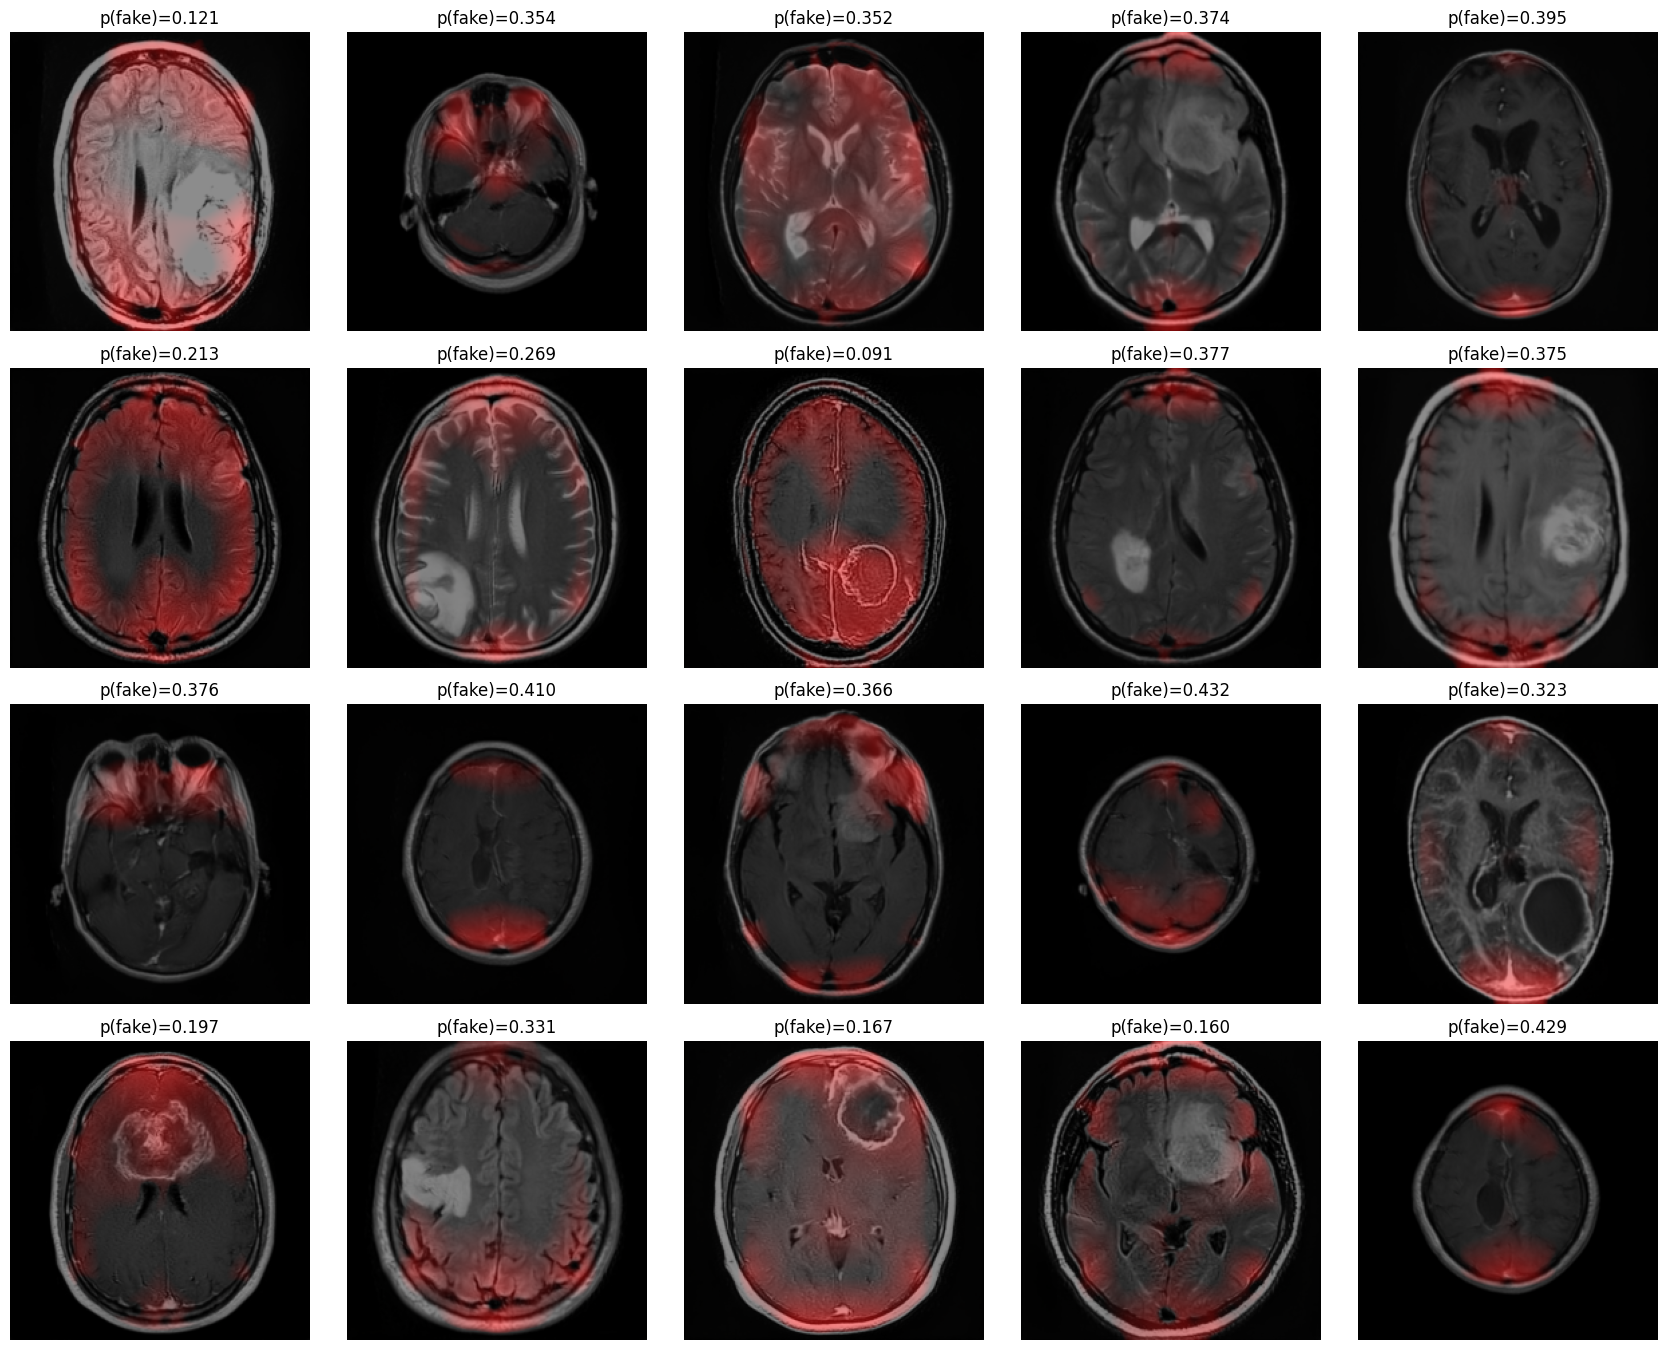

In [ ]:
import os, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import cv2  # (가우시안 블러용)

# ============================================================
# 사용자 설정
# ============================================================
model_path = r"/content/drive/MyDrive/MRI_hybrid_checkpoints/HybridMobileNetV2_Forensics_best.pth"
test_root  = r"/content/drive/MyDrive/MRI_test"
img_size   = 224
num_samples= 20
thr        = 0.7  # heatmap 강조 임계값
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)

# ============================================================
# 데이터 변환
# ============================================================
test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ============================================================
# 주파수 특성 추출기
# ============================================================
class SRMExtractor(nn.Module):
    def __init__(self, out_ch=64):
        super().__init__()
        kernels = [
            [[0,0,0],[0,1,-1],[0,0,0]],
            [[0,0,0],[1,-2,1],[0,0,0]],
            [[0,1,0],[1,-4,1],[0,1,0]],
            [[-1,2,-1],[2,-4,2],[-1,2,-1]],
            [[1,-1,0],[-1,0,1],[0,1,-1]],
            [[0,-1,0],[-1,4,-1],[0,-1,0]],
            [[-1,0,1],[0,0,0],[1,0,-1]],
            [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]],
            [[2,-1,2],[-1,-4,-1],[2,-1,2]],
        ]
        k = torch.tensor(kernels, dtype=torch.float32).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(len(kernels), out_ch, 1, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, affine=False)
        self.act  = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))
    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))

class HPFExtractor(nn.Module):
    def __init__(self, out_ch=96):
        super().__init__()
        lap = torch.tensor([[0,-1,0],[-1,4,-1],[0,-1,0]], dtype=torch.float32)
        sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32)
        sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32)
        sharp   = torch.tensor([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=torch.float32)
        k = torch.stack([lap, sobel_x, sobel_y, sharp], dim=0).unsqueeze(1)
        self.register_buffer('kernel', k)
        self.proj = nn.Conv2d(4, out_ch, 1, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch, affine=False)
        self.act  = nn.ReLU(inplace=True)
        self.register_buffer('rgb2gray', torch.tensor([0.2989,0.5870,0.1140]).view(1,3,1,1))
    def forward(self, x):
        gray = (x * self.rgb2gray.to(x.device)).sum(1, keepdim=True)
        hf = F.conv2d(gray, self.kernel.to(x.device), padding=1)
        hf = torch.abs(hf)
        hf = self.proj(hf)
        return self.act(self.bn(hf))

# ============================================================
# Hybrid MobileNetV2 Forensics 모델
# ============================================================
class HybridMobileNetV2Forensics(nn.Module):
    def __init__(self, num_classes=2, topk_ratio=0.06, dropout_p=0.2):
        super().__init__()
        self.backbone = models.mobilenet_v2(weights=None).features
        self.bn_last  = nn.BatchNorm2d(1280)
        self.act      = nn.ReLU6(inplace=True)
        self.srm = SRMExtractor(out_ch=64)
        self.hpf = HPFExtractor(out_ch=96)
        merged_ch = 1280 + 64 + 96
        self.dropout = nn.Dropout(dropout_p)
        self.classifier_map = nn.Conv2d(merged_ch, num_classes, kernel_size=1, bias=True)
        self.topk_ratio = topk_ratio
    def forward(self, x, return_map=False):
        feat = self.act(self.bn_last(self.backbone(x)))
        B,_,h,w = feat.shape
        srm = F.adaptive_avg_pool2d(self.srm(x), (h,w))
        hpf = F.adaptive_avg_pool2d(self.hpf(x), (h,w))
        x_cat = torch.cat([feat, srm, hpf], dim=1)
        x_cat = self.dropout(x_cat)
        logit_map = self.classifier_map(x_cat)
        if return_map:
            return logit_map
        # MIL pooling
        B, C, H, W = logit_map.shape
        pooled = []
        for c in range(C):
            lc = logit_map[:, c].reshape(B, -1)
            k = max(1, int(self.topk_ratio * lc.shape[1]))
            _, idx = torch.topk(lc, k, dim=1)
            mask = torch.zeros_like(lc); mask.scatter_(1, idx, 1.0)
            mask = mask.view(B, 1, H, W)
            pc = (logit_map[:, c:c+1] * mask).sum(dim=(2,3)) / mask.sum(dim=(2,3)).clamp_min(1.0)
            pooled.append(pc)
        return torch.cat(pooled, dim=1)

# ============================================================
# 체크포인트 로드
# ============================================================
ckpt = torch.load(model_path, map_location=device)
state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
if any(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k[len("module."):]: v for k,v in state_dict.items()}

model = HybridMobileNetV2Forensics(num_classes=2, topk_ratio=0.06).to(device)
model.load_state_dict(state_dict, strict=False)
model.eval()

# ============================================================
# 데이터셋 준비
# ============================================================
test_ds = datasets.ImageFolder(root=test_root, transform=test_tf)
class_to_idx = test_ds.class_to_idx
cls_fake = class_to_idx.get("fake", 0)
fake_indices = [i for i,(_,y) in enumerate(test_ds.samples) if y == cls_fake]
random.shuffle(fake_indices)
fake_indices = fake_indices[:num_samples]
subset = Subset(test_ds, fake_indices)

# ============================================================
# 시각화 도우미
# ============================================================
inv_mean = torch.tensor([0.485,0.456,0.406]).view(1,3,1,1)
inv_std  = torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)
def denorm(x): return (x * inv_std.to(x.device) + inv_mean.to(x.device)).clamp(0,1)

def strong_overlay(base_img_hw3, mask_hw, alpha=0.45, thr=0.7, color="red"):
    """
    threshold 이상 부분만 밝은 색 오버레이하되,
    mask를 가우시안 블러로 부드럽게 만들어 자연스러운 그라데이션 효과를 냄.
    """
    h, w = mask_hw.shape

    # --- 1️⃣ 가우시안 블러로 mask를 부드럽게 ---
    mask_blur = cv2.GaussianBlur(mask_hw, (17, 17), 0)
    mask_blur = (mask_blur - mask_blur.min()) / (mask_blur.max() - mask_blur.min() + 1e-12)

    # --- 2️⃣ threshold 기반 강조 ---
    soft_mask = np.clip((mask_blur - thr) / (1 - thr + 1e-12), 0, 1)  # thr 부근은 점진적으로 증가

    # --- 3️⃣ 색상 채널 구성 ---
    color_map = np.zeros((h,w,3), dtype=np.float32)
    if color == "red":
        color_map[...,0] = soft_mask
    elif color == "green":
        color_map[...,1] = soft_mask
    elif color == "blue":
        color_map[...,2] = soft_mask

    # --- 4️⃣ 합성 ---
    overlay = np.clip((1-alpha)*base_img_hw3 + alpha*color_map, 0, 1)
    return overlay

# ============================================================
# Fake 시각화 (Softmax + 반전 + 배경마스크)
# ============================================================
cols = 5
rows = int(np.ceil(num_samples / cols))
plt.figure(figsize=(3.4*cols, 3.4*rows))
shown = 0

with torch.no_grad():
    for idx_in_subset in range(len(subset)):
        x, y = subset[idx_in_subset]
        x = x.unsqueeze(0).to(device)

        # 확률 계산
        probs = F.softmax(model(x), dim=1)[0, cls_fake].item()
        logit_map = model(x, return_map=True)          # 1x2xhxw
        prob_map = F.softmax(logit_map, dim=1)[0, cls_fake]  # fake 확률맵

        # 업샘플링
        prob_map = F.interpolate(prob_map.unsqueeze(0).unsqueeze(0),
                                 size=(img_size, img_size),
                                 mode='bilinear', align_corners=False)[0,0]

        # 정규화 + 반전
        fmap = prob_map.cpu().numpy()
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-12)
        fmap = 1 - fmap  # 반전

        # 원본 복원
        x_den = denorm(x).cpu()[0].permute(1,2,0).numpy()

        # MRI 배경 제거 마스크
        gray = np.mean(x_den, axis=2)
        brain_mask = (gray > 0.05).astype(np.float32)
        fmap = fmap * brain_mask

        # 오버레이 생성
        overlay = strong_overlay(x_den, fmap, alpha=0.45, thr=thr, color="red")

        shown += 1
        plt.subplot(rows, cols, shown)
        plt.imshow(overlay)
        plt.axis("off")
        plt.title(f"p(fake)={probs:.3f}")

        if shown >= num_samples:
            break

if shown == 0:
    print("fake 예측된 이미지가 없습니다.")
else:
    plt.tight_layout()
    plt.show()


#==========================
#- - - - - -< 최종 V1 / V2 >- - - - - - -
#==========================

##V1 / V2 학습

In [ ]:
#튜닝 전
# =========================
# MobileNet V1/V2 Supervised REAL vs FAKE Training Pipeline
# =========================
import os, random, io, math
from PIL import Image
from glob import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF

# =========================
# Model Implementations
# =========================

# 1. MobileNetV1
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.depthwise(x)))
        x = F.relu(self.bn2(self.pointwise(x)))
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layers = nn.Sequential(
            DepthwiseSeparableConv(32, 64, 1),
            DepthwiseSeparableConv(64, 128, 2),
            DepthwiseSeparableConv(128, 128, 1),
            DepthwiseSeparableConv(128, 256, 2),
            DepthwiseSeparableConv(256, 256, 1),
            DepthwiseSeparableConv(256, 512, 2),
            DepthwiseSeparableConv(512, 512, 1),
            DepthwiseSeparableConv(512, 512, 1),
            DepthwiseSeparableConv(512, 512, 1),
            DepthwiseSeparableConv(512, 512, 1),
            DepthwiseSeparableConv(512, 512, 1),
            DepthwiseSeparableConv(512, 1024, 2),
            DepthwiseSeparableConv(1024, 1024, 1),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# 2. MobileNetV2
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ])

        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layers = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 320, 1, 6),
        )

        self.conv_last = nn.Conv2d(320, 1280, 1, bias=False)
        self.bn_last = nn.BatchNorm2d(1280)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = F.relu6(self.bn_last(self.conv_last(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# =========================
# Training Configuration & Data Setup
# =========================

# 1) Paths & hyperparams
data_root = "/content/drive/MyDrive/MRI_train"
save_dir = "/content/drive/MyDrive/MRI_v1v2_checkpoints"
os.makedirs(save_dir, exist_ok=True)

img_size = 224
batch_size = 16
epochs = 60
lr = 1e-3
weight_decay= 1e-4
patience = 5 # early stopping patience

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] device={device}")

# 2) Reproducibility
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_all(42)

# Eval: 표준 변환(증강 없음)
eval_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
train_tf = eval_tf  # 증강 제거

# 4) Dataset split
full_ds = datasets.ImageFolder(root=data_root) # transform은 아래에서 개별 적용
class_to_idx = full_ds.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("[INFO] classes:", class_to_idx)

# stratified split (90% train / 10% val)
targets = [y for _,y in full_ds.samples]
indices_by_class = {}
for i,y in enumerate(targets):
    indices_by_class.setdefault(y, []).append(i)

train_idx, val_idx = [], []
val_ratio = 0.1
random.seed(42)
for y, idxs in indices_by_class.items():
    random.shuffle(idxs)
    n_val = max(1, int(len(idxs)*val_ratio))
    val_idx.extend(idxs[:n_val])
    train_idx.extend(idxs[n_val:])

# Windows에서 multiprocessing 문제를 피하기 위해 간단한 방법 사용
from torch.utils.data import Subset

# 전체 데이터셋에 transform 적용
train_full_ds = datasets.ImageFolder(root=data_root, transform=train_tf)
val_full_ds = datasets.ImageFolder(root=data_root, transform=eval_tf)

# Subset으로 분할
train_ds = Subset(train_full_ds, train_idx)
val_ds = Subset(val_full_ds, val_idx)

# Windows에서는 num_workers=0으로 설정하여 multiprocessing 비활성화
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"[INFO] train={len(train_ds)} val={len(val_ds)}")

# =========================
# Training Functions
# =========================

def run_epoch(model, loader, criterion, optimizer=None, train_mode=True):
    model.train() if train_mode else model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            out = model(x)
            loss = criterion(out, y)

            if train_mode:
                loss.backward()
                optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        if i % 10 == 0:
            print(f" batch {i:05d}/{len(loader):05d} | loss {loss.item():.4f}", flush=True)

    return loss_sum / max(1, total), 100.0 * correct / max(1, total)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    cm = torch.zeros(2, 2, dtype=torch.int64)
    total, correct = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)

        for t, p in zip(y.view(-1), pred.view(-1)):
            cm[t.long(), p.long()] += 1

        total += y.size(0)
        correct += (pred == y).sum().item()

    acc = 100.0 * correct / max(1, total)
    return acc, cm

def print_cm(tag, acc, cm):
    print(f"\n=== {tag} ===")
    print(f"Accuracy: {acc:.2f}%")
    print(f"Confusion Matrix:")
    print(f" pred-> class0 class1")
    print(f"true 0 {int(cm[0,0]):6d} {int(cm[0,1]):6d}")
    print(f"true 1 {int(cm[1,0]):6d} {int(cm[1,1]):6d}")

def train_model(model, model_name):
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # class weighting (optional)
    from collections import Counter
    train_targets = [targets[i] for i in train_idx]
    cnt = Counter(train_targets)
    weights = torch.tensor([1.0/cnt[c] for c in range(len(cnt))], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val = float('inf')
    wait = 0
    best_path = os.path.join(save_dir, f'{model_name}_best.pth')

    start_time = time.time()

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer, True)
        vl_loss, vl_acc = run_epoch(model, val_loader, criterion, None, False)
        scheduler.step(vl_loss)

        print(f"Epoch {ep:02d}/{epochs} | train_loss {tr_loss:.4f} acc {tr_acc:.2f}% | val_loss {vl_loss:.4f} acc {vl_acc:.2f}%")

        # Best-only 저장
        if vl_loss < best_val:
            best_val, wait = vl_loss, 0
            torch.save(model.state_dict(), best_path)
            print(f" 💾 Best updated: {best_path} (val_loss={best_val:.4f})")

        else:
            wait += 1
            if wait >= patience:
                print(" ⛳ Early stopped.")
                break


    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # 마지막 모델도 저장
    last_path = os.path.join(save_dir, f'{model_name}_last.pth')
    torch.save(model.state_dict(), last_path)
    print(f"✅ Saved last: {last_path}")

    return best_path, training_time

def evaluate_model(model, model_name, best_path):
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")

    # best 모델 로드
    model.load_state_dict(torch.load(best_path, map_location=device))
    model = model.to(device)

    def make_loader(tf):
        ds = datasets.ImageFolder(root=data_root, transform=tf)
        return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

    # A) 기본
    acc, cm = evaluate(model, val_loader)
    print_cm("Eval (baseline)", acc, cm)


# =========================
# Main Training Pipeline
# =========================

if __name__ == '__main__':
    models_to_train = [
        ("MobileNetV1", MobileNetV1),
        ("MobileNetV2", MobileNetV2),
    ]

    results = {}

    print(f"Starting MobileNet training pipeline...")
    print(f"Total models to train: {len(models_to_train)}")
    print(f"Classes mapping: {idx_to_class}")

    for i, (model_name, model_class) in enumerate(models_to_train):
        print(f"\n🚀 [{i+1}/{len(models_to_train)}] Starting {model_name}")

        try:
            # 모델 초기화
            model = model_class(num_classes=2).to(device)

            # 모델 파라미터 수 계산
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Total parameters: {total_params:,}")
            print(f"Trainable parameters: {trainable_params:,}")

            # 학습
            best_path, training_time = train_model(model, model_name)

            # 평가
            evaluate_model(model, model_name, best_path)

            # 결과 저장
            results[model_name] = {
                'best_path': best_path,
                'training_time': training_time,
                'total_params': total_params,
                'trainable_params': trainable_params
            }

            print(f"✅ {model_name} completed successfully!")

            # GPU 메모리 정리
            del model
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"❌ Error training {model_name}: {str(e)}")
            results[model_name] = {'error': str(e)}

            # 에러 발생시에도 메모리 정리
            torch.cuda.empty_cache()
            continue

    # =========================
    # Final Results Summary
    # =========================

    print(f"\n{'='*60}")
    print("FINAL RESULTS SUMMARY")
    print(f"{'='*60}")

    for model_name, result in results.items():
        if 'error' in result:
            print(f"{model_name:15} | ERROR: {result['error']}")
        else:
            print(f"{model_name:15} | Time: {result['training_time']:6.1f}s | Params: {result['total_params']:8,} | Best: {result['best_path']}")

    print(f"\n✅ MobileNet training pipeline completed!")
    print(f"Results saved in: {save_dir}")
    print(f"Classes mapping: {idx_to_class} (e.g., 0:'{idx_to_class.get(0)}', 1:'{idx_to_class.get(1)}')")

[INFO] device=cuda
[INFO] classes: {'fake': 0, 'real': 1}
[INFO] train=880 val=97
Starting MobileNet training pipeline...
Total models to train: 2
Classes mapping: {0: 'fake', 1: 'real'}

🚀 [1/2] Starting MobileNetV1
Total parameters: 3,209,026
Trainable parameters: 3,209,026

Training MobileNetV1
 batch 00000/00055 | loss 0.6901
 batch 00010/00055 | loss 0.6698
 batch 00020/00055 | loss 0.5429
 batch 00030/00055 | loss 0.4956
 batch 00040/00055 | loss 0.4788
 batch 00050/00055 | loss 0.4849
 batch 00000/00007 | loss 3.1798
Epoch 01/60 | train_loss 0.5929 acc 66.02% | val_loss 1.6415 acc 50.52%
 💾 Best updated: /content/drive/MyDrive/MRI_v1v2_checkpoints/MobileNetV1_best.pth (val_loss=1.6415)
 batch 00000/00055 | loss 0.4573
 batch 00010/00055 | loss 0.1973
 batch 00020/00055 | loss 0.3314
 batch 00030/00055 | loss 0.2297
 batch 00040/00055 | loss 0.0989
 batch 00050/00055 | loss 0.0434
 batch 00000/00007 | loss 0.0247
Epoch 02/60 | train_loss 0.2116 acc 91.36% | val_loss 2.2654 acc 55

## V1 / V2 테스트

In [ ]:
import os, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# -------------------
# MobileNetV1 정의
# -------------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.depthwise(x)))
        x = F.relu(self.bn2(self.pointwise(x)))
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = nn.Sequential(
            DepthwiseSeparableConv(32, 64, 1),
            DepthwiseSeparableConv(64, 128, 2),
            DepthwiseSeparableConv(128, 128, 1),
            DepthwiseSeparableConv(128, 256, 2),
            DepthwiseSeparableConv(256, 256, 1),
            DepthwiseSeparableConv(256, 512, 2),
            *[DepthwiseSeparableConv(512, 512, 1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, 2),
            DepthwiseSeparableConv(1024, 1024, 1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# -------------------
# MobileNetV2 정의
# -------------------
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels
        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ])
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 320, 1, 6),
        )
        self.conv_last = nn.Conv2d(320, 1280, 1, bias=False)
        self.bn_last = nn.BatchNorm2d(1280)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = F.relu6(self.bn_last(self.conv_last(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# -------------------
# 여기부터 테스트 로직 (앞서 준 evaluate/test_loader 부분 붙이기)
# -------------------


# -------------------
# 설정
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
batch_size = 16

test_root = "/content/drive/MyDrive/MRI_test"  # fake, real 구조
checkpoint_dir = "/content/drive/MyDrive/MRI_v1v2_checkpoints"

# 평가용 transform (augmentation 없음)
test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# 데이터셋 로드
test_ds = datasets.ImageFolder(root=test_root, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

idx_to_class = {v:k for k,v in test_ds.class_to_idx.items()}
print("[INFO] test classes:", idx_to_class)


# -------------------
# 평가 함수
# -------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    cm = torch.zeros(2, 2, dtype=torch.int64)
    total, correct = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)

        for t, p in zip(y.view(-1), pred.view(-1)):
            cm[t.long(), p.long()] += 1

        total += y.size(0)
        correct += (pred == y).sum().item()

    acc = 100.0 * correct / max(1, total)
    return acc, cm

def print_cm(tag, acc, cm):
    print(f"\n=== {tag} ===")
    print(f"Accuracy: {acc:.2f}%")
    print(f"Confusion Matrix:")
    print(f" pred-> fake  real")
    print(f"true fake {int(cm[0,0]):6d} {int(cm[0,1]):6d}")
    print(f"true real {int(cm[1,0]):6d} {int(cm[1,1]):6d}")


# -------------------
# 실행
# -------------------
if __name__ == "__main__":
    models_to_eval = [
        ("MobileNetV1", MobileNetV1),
        ("MobileNetV2", MobileNetV2),
    ]

    for model_name, model_class in models_to_eval:
        best_path = os.path.join(checkpoint_dir, f"{model_name}_best.pth")
        if not os.path.exists(best_path):
            print(f"❌ {best_path} not found, skip.")
            continue

        model = model_class(num_classes=2).to(device)
        model.load_state_dict(torch.load(best_path, map_location=device))

        acc, cm = evaluate(model, test_loader)
        print_cm(f"Test {model_name}", acc, cm)


[INFO] test classes: {0: 'fake', 1: 'real'}

=== Test MobileNetV1 ===
Accuracy: 67.10%
Confusion Matrix:
 pred-> fake  real
true fake    192    308
true real     21    479

=== Test MobileNetV2 ===
Accuracy: 68.70%
Confusion Matrix:
 pred-> fake  real
true fake    193    307
true real      6    494


[INFO] test classes: {0: 'fake', 1: 'real'}


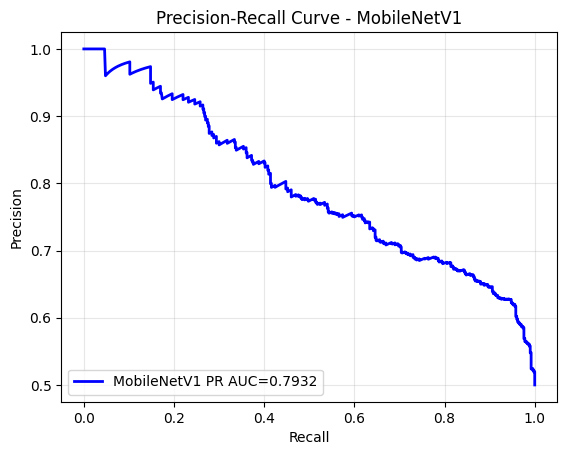


=== Test MobileNetV1 ===
Accuracy: 67.10%
Confusion Matrix:
 pred-> fake  real
true fake    192    308
true real     21    479


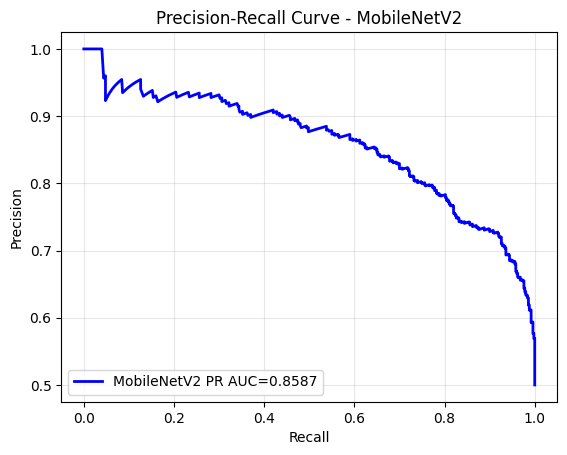


=== Test MobileNetV2 ===
Accuracy: 68.70%
Confusion Matrix:
 pred-> fake  real
true fake    193    307
true real      6    494


In [4]:
import os, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# -------------------
# MobileNetV1 정의
# -------------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.depthwise(x)))
        x = F.relu(self.bn2(self.pointwise(x)))
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = nn.Sequential(
            DepthwiseSeparableConv(32, 64, 1),
            DepthwiseSeparableConv(64, 128, 2),
            DepthwiseSeparableConv(128, 128, 1),
            DepthwiseSeparableConv(128, 256, 2),
            DepthwiseSeparableConv(256, 256, 1),
            DepthwiseSeparableConv(256, 512, 2),
            *[DepthwiseSeparableConv(512, 512, 1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, 2),
            DepthwiseSeparableConv(1024, 1024, 1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# -------------------
# MobileNetV2 정의
# -------------------
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels
        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
            ])
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 160, 1, 6),
            InvertedResidual(160, 320, 1, 6),
        )
        self.conv_last = nn.Conv2d(320, 1280, 1, bias=False)
        self.bn_last = nn.BatchNorm2d(1280)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = F.relu6(self.bn1(self.conv1(x)))
        x = self.layers(x)
        x = F.relu6(self.bn_last(self.conv_last(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# -------------------
# 설정
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 224
batch_size = 16
test_root = "/content/drive/MyDrive/MRI_test"
checkpoint_dir = "/content/drive/MyDrive/MRI_v1v2_checkpoints"

test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_ds = datasets.ImageFolder(root=test_root, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
idx_to_class = {v:k for k,v in test_ds.class_to_idx.items()}
print("[INFO] test classes:", idx_to_class)

# -------------------
# 평가 함수 (PR Curve)
# -------------------
@torch.no_grad()
def evaluate(model, loader, model_name):
    model.eval()
    cm = torch.zeros(2, 2, dtype=torch.int64)
    all_labels, all_probs = [], []
    total, correct = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        probs = F.softmax(out, dim=1)[:, 1]  # fake 클래스 확률
        preds = out.argmax(1)

        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        for t, p in zip(y.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1

        total += y.size(0)
        correct += (preds == y).sum().item()

    acc = 100.0 * correct / max(1, total)

    # Precision-Recall Curve 시각화
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'{model_name} PR AUC={pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

    return acc, cm

def print_cm(tag, acc, cm):
    print(f"\n=== {tag} ===")
    print(f"Accuracy: {acc:.2f}%")
    print(f"Confusion Matrix:")
    print(f" pred-> fake  real")
    print(f"true fake {int(cm[0,0]):6d} {int(cm[0,1]):6d}")
    print(f"true real {int(cm[1,0]):6d} {int(cm[1,1]):6d}")

# -------------------
# 실행
# -------------------
if __name__ == "__main__":
    models_to_eval = [
        ("MobileNetV1", MobileNetV1),
        ("MobileNetV2", MobileNetV2),
    ]

    for model_name, model_class in models_to_eval:
        best_path = os.path.join(checkpoint_dir, f"{model_name}_best.pth")
        if not os.path.exists(best_path):
            print(f"❌ {best_path} not found, skip.")
            continue

        model = model_class(num_classes=2).to(device)
        model.load_state_dict(torch.load(best_path, map_location=device))

        acc, cm = evaluate(model, test_loader, model_name)
        print_cm(f"Test {model_name}", acc, cm)


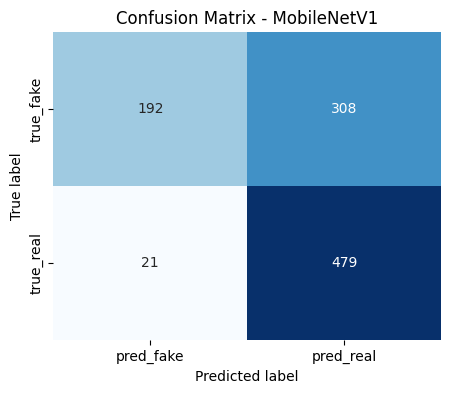

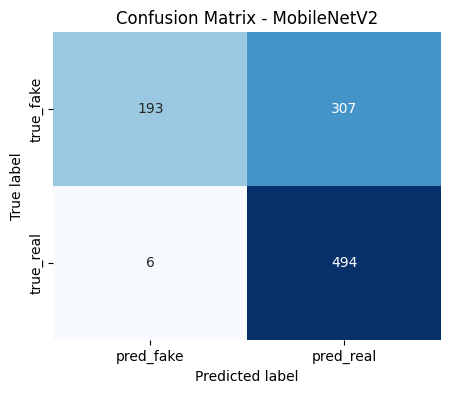

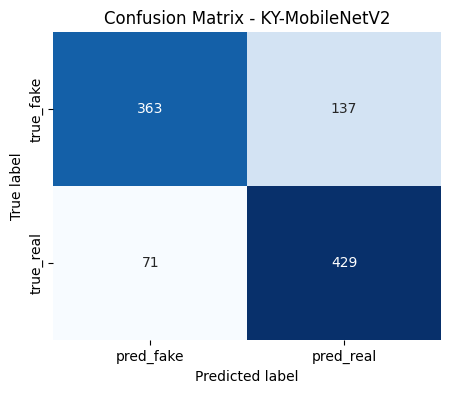

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 모델별 Confusion Matrix
v1_cm = np.array([[192, 308],[21, 479]])
v2_cm = np.array([[193, 307],[6, 494]])
v3_cm = np.array([[363, 137],[71, 429]])

cms = [v1_cm, v2_cm, v3_cm]
model_names = ['MobileNetV1', 'MobileNetV2', 'KY-MobileNetV2']

# 모델별로 따로 출력
for cm, name in zip(cms, model_names):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False,
                xticklabels=['pred_fake','pred_real'], yticklabels=['true_fake','true_real'])
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


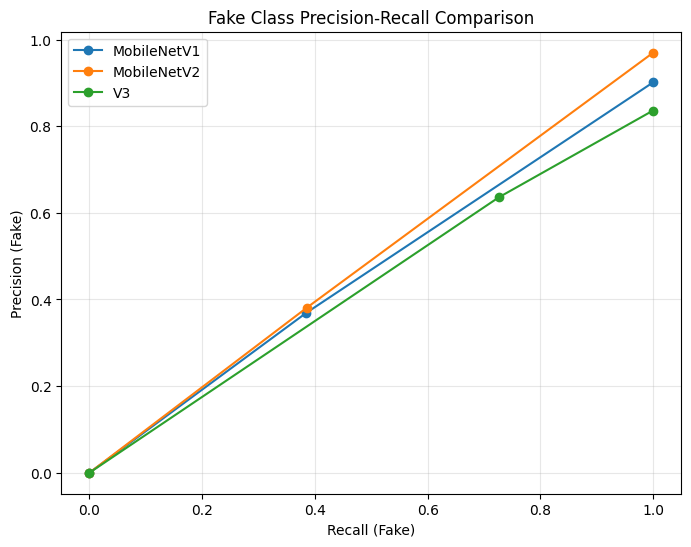

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Confusion Matrix에서 TP/FP/FN/TN 값 정의
v1_cm = np.array([[192, 308],[21, 479]])
v2_cm = np.array([[193, 307],[6, 494]])
v3_cm = np.array([[363, 137],[71, 429]])

# Fake 클래스 기준 Precision & Recall 계산용
def pr_from_cm(cm):
    TP = cm[0,0]
    FP = cm[1,0]
    FN = cm[0,1]
    # Precision, Recall points for PR curve
    precision = [TP/(TP+FP), TP/(TP+FP+FN), 0]
    recall = [1, TP/(TP+FN), 0]
    return recall, precision

curves = [pr_from_cm(cm) for cm in [v1_cm, v2_cm, v3_cm]]
labels = ['MobileNetV1','MobileNetV2','V3']

plt.figure(figsize=(8,6))
for (recall, precision), label in zip(curves, labels):
    plt.plot(recall, precision, marker='o', label=label)
plt.xlabel('Recall (Fake)')
plt.ylabel('Precision (Fake)')
plt.title('Fake Class Precision-Recall Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
